# Personal Information
Name: **Wouter Knibbe**

StudentID: **12795526**

Email: [**wouter.knibbe@student.uva.nl**](wouter.knibbe@student.uva.nl)

Github **https://github.com/WouterKnibbe/ATSP_hillForHard**

Submitted on: **05.03.2024**

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import algorithm

In [2]:
def mutate_matrix(_matrix, _upper, _print):
    matrix = _matrix.copy()
    number1, number2 = 0, 0

    while number1 == number2:
        number1, number2 = np.random.randint(0,matrix.shape[0]), np.random.randint(0,matrix.shape[0])
    previous_number = matrix[number1,number2]
    while matrix[number1,number2] == previous_number:
        matrix[number1,number2] = np.random.randint(1,_upper)
    if _print:
        print(_matrix[number1,number2].round(1), "at", (number1,number2), "becomes", matrix[number1,number2].round(1))

    return matrix

In [3]:
def custom_encoder(obj):
    """
    Custom JSON encoder function that converts non-serializable objects.
    Converts:
    - numpy arrays to lists
    - numpy int64 to int
    - numpy float64 to float
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.inf):
        return "np.inf"
    else:
        # This will raise a TypeError for unknown types
        raise TypeError(f"Object of type '{obj.__class__.__name__}' is not JSON serializable")

def save_merged(results, citysize, range):

    x = 0
    while True:
        file_path = f"Results/results{citysize}_{range}_m.json"
        if not os.path.exists(file_path):
            break
        x += 1

    # Dumping the nested_dict to a json file with custom encoding
    with open(file_path, "w") as json_file:
        json.dump(results, json_file, default=custom_encoder)

    print(f"Results saved to JSON file successfully as {file_path}")

In [4]:
def custom_decoder(obj):
    """
    Custom decoder function that converts specific JSON values back to their original types.
    Converts:
    - 'Infinity' to np.inf
    """
    if isinstance(obj, dict):
        for key, value in obj.items():
            if value == "Infinity":
                obj[key] = np.inf
            # elif isinstance(value, list):
                # Convert lists back to arrays
                # obj[key] = np.array(value)
            elif isinstance(value, dict):
                obj[key] = custom_decoder(value)
    elif isinstance(obj, list):
        for i, value in enumerate(obj):
            if value == "Infinity":
                obj[i] = np.inf
            # elif isinstance(value, list):
                # obj[i] = np.array(value)
            elif isinstance(value, dict):
                obj[i] = custom_decoder(value)
    return obj

def load_result(file_path):

  # Loading the JSON file with custom decoding
  with open(file_path, "r") as json_file:
      loaded_results = json.load(json_file, object_hook=custom_decoder)

  return loaded_results

### Combine files

In [5]:
# import re

# cities = [30, 50]
# ranges = [15, 20]

# for city in cities:
#     for range_val in ranges:
#         # Construct the directory path
#         directory_path = f"Results"
        
#         # Get all files in the directory
#         files = os.listdir(directory_path)
        
#         # Filter files based on the pattern: results{city}_{range}_x.json where x is any number
#         pattern = re.compile(rf'^results{city}_{range_val}_\d+\.json$')
#         json_files = [file for file in files if pattern.match(file)]

#         # Proceed if there are any matching files
#         if json_files and len(json_files) > 1:
#             # Sort files to maintain order, assuming numeric sorting is desired
#             json_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

#             # Load the initial dictionary from the first file
#             base_dict = load_result(os.path.join(directory_path, json_files[0]))
#             last_key = max([int(k) for k in base_dict.keys()], default=0)

#             # Merge the remaining dictionaries
#             for file in json_files[1:]:  # Skip the first file as it's already loaded
#                 current_dict = load_result(os.path.join(directory_path, file))
#                 adjusted_dict = {str(int(key) + last_key): value for key, value in current_dict.items()}
#                 base_dict.update(adjusted_dict)
#                 last_key = max([int(k) for k in base_dict.keys()])

#             # Save the merged dictionary
#             save_merged(base_dict, city, range_val)

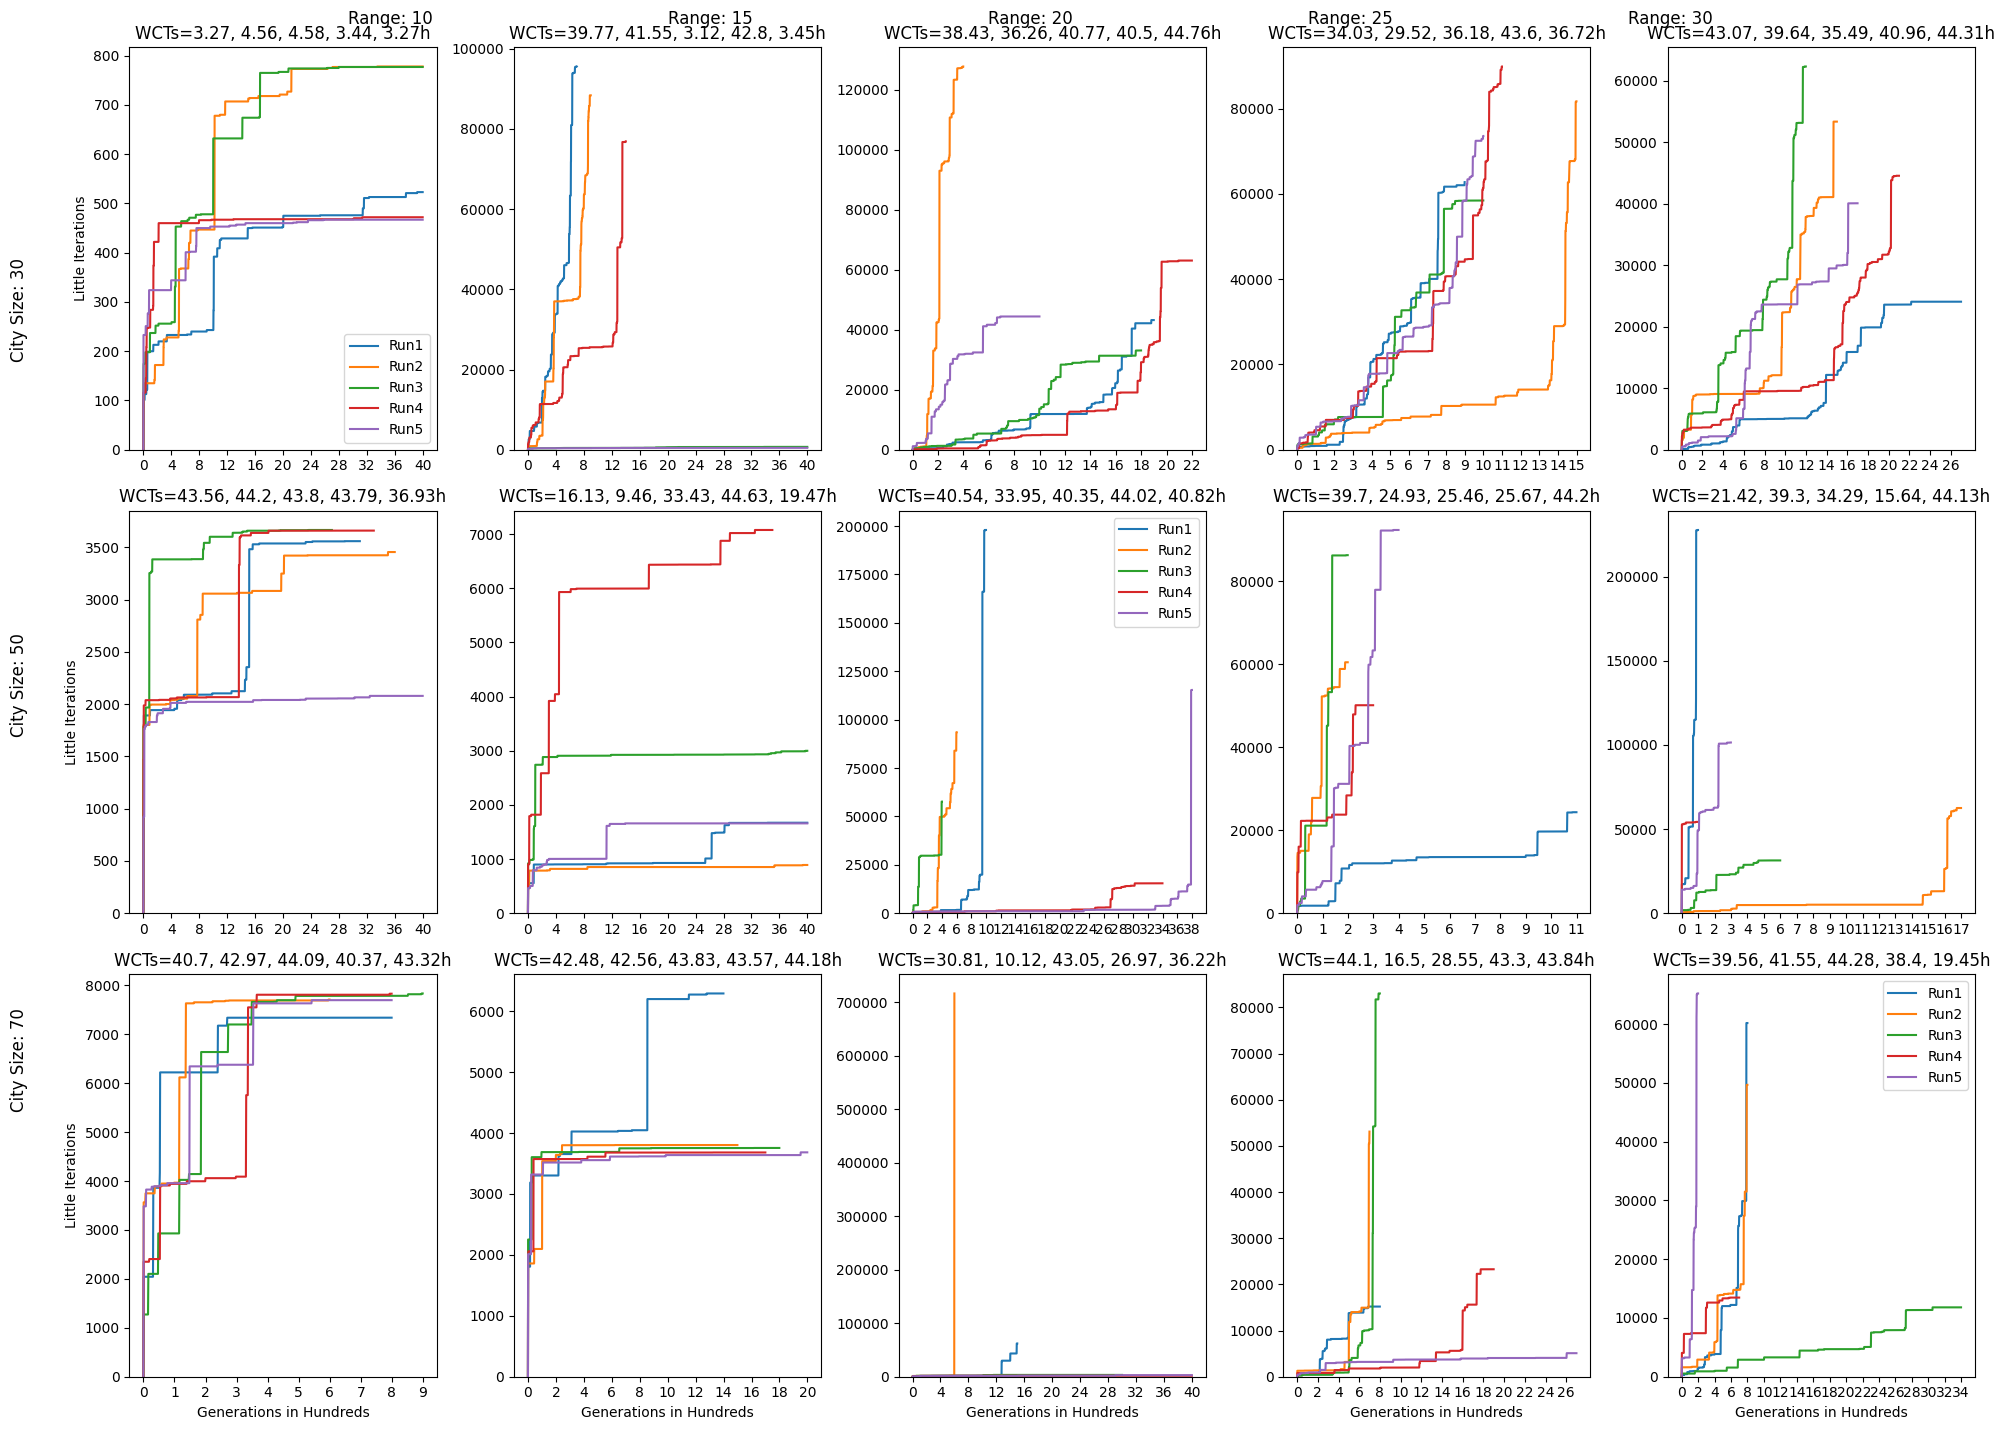

In [37]:
cities = [30, 50, 70]
ranges = [10, 15, 20, 25, 30]

results_path = 'Results/'
runs = [name for name in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, name))]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 15)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        max_x_values = []
        run_data = []
        times = np.zeros(len(runs))

        for k, run in enumerate(runs):
            base_path = f"Results/{run}/results{city}_{range_val}"
            file_paths = [base_path + '.json']
            # Automatically add files that are extensions of the main file
            part_num = 0
            while os.path.exists(base_path + f'_{part_num}.json'):
                file_paths.append(base_path + f'_{part_num}.json')
                part_num += 1

            combined_x_values = []
            combined_y_values = []

            for path in file_paths:
                try:
                    loaded = load_result(path)
                except:
                    continue

                for hundred_gens in loaded:
                    
                    times[k] = hundred_gens[0]
                    current_x_values = list(hundred_gens[1].keys())
                    current_y_values_1 = [values[1] for values in hundred_gens[1].values()]

                    combined_x_values.extend(current_x_values)
                    combined_y_values.extend(current_y_values_1)

            if len(combined_x_values) > len(max_x_values):
                max_x_values = combined_x_values
            run_data.append((combined_x_values, combined_y_values))

        ax = axs[i, j] if subplot_rows > 1 and subplot_cols > 1 else axs[max(i, j)]

        # Plot combined data for each run
        for x_vals, y_vals in run_data:
            ax.plot(x_vals, y_vals)

        xticklist = list(range(0, int(max_x_values[-1]) + 5, 100))
        if len(xticklist) > 39:
            xticklist = xticklist[::4]
        elif len(xticklist) > 19:
            xticklist = xticklist[::2]

        ax.set_xticks(xticklist)
        ax.set_xticklabels([f"{x//100}" for x in xticklist])
        
        all_y_values = [y for _, y in run_data for y in y]
        ax.set_ylim(bottom=min(all_y_values)-(min(all_y_values)/7))
        if j == 0:
            ax.set_ylabel('Little Iterations')
        if i == 2:
            ax.set_xlabel('Generations in Hundreds')
        formatted_string = ', '.join(map(str, (times/3600).round(2)))
        ax.set_title(f'WCTs={formatted_string}h')
        
        if (i == 0 and j == 0) or (i == 1 and j == 2) or (i == 2 and j == 4):
            ax.legend(['Run1', 'Run2', 'Run3', 'Run4', 'Run5'])

# Label the rows and columns
for idx, city in enumerate(cities):
    fig.text(0.01, 0.75 - idx * 0.25, f'City Size: {city}', va='center', ha='left', rotation='vertical', fontsize=12)

for idx, range_val in enumerate(ranges):
    fig.text(0.2 + idx * 0.16, 0.95, f'Range: {range_val}', ha='center', va='top', fontsize=12)

plt.tight_layout(rect=[0.03, 0, 1, 0.95])  # Adjust the layout to make room for labels
plt.show()

In [7]:
kek = load_result("Results/6019314_run2/results30_15.json")

In [35]:
kek[-1][0]

149576.41615891457

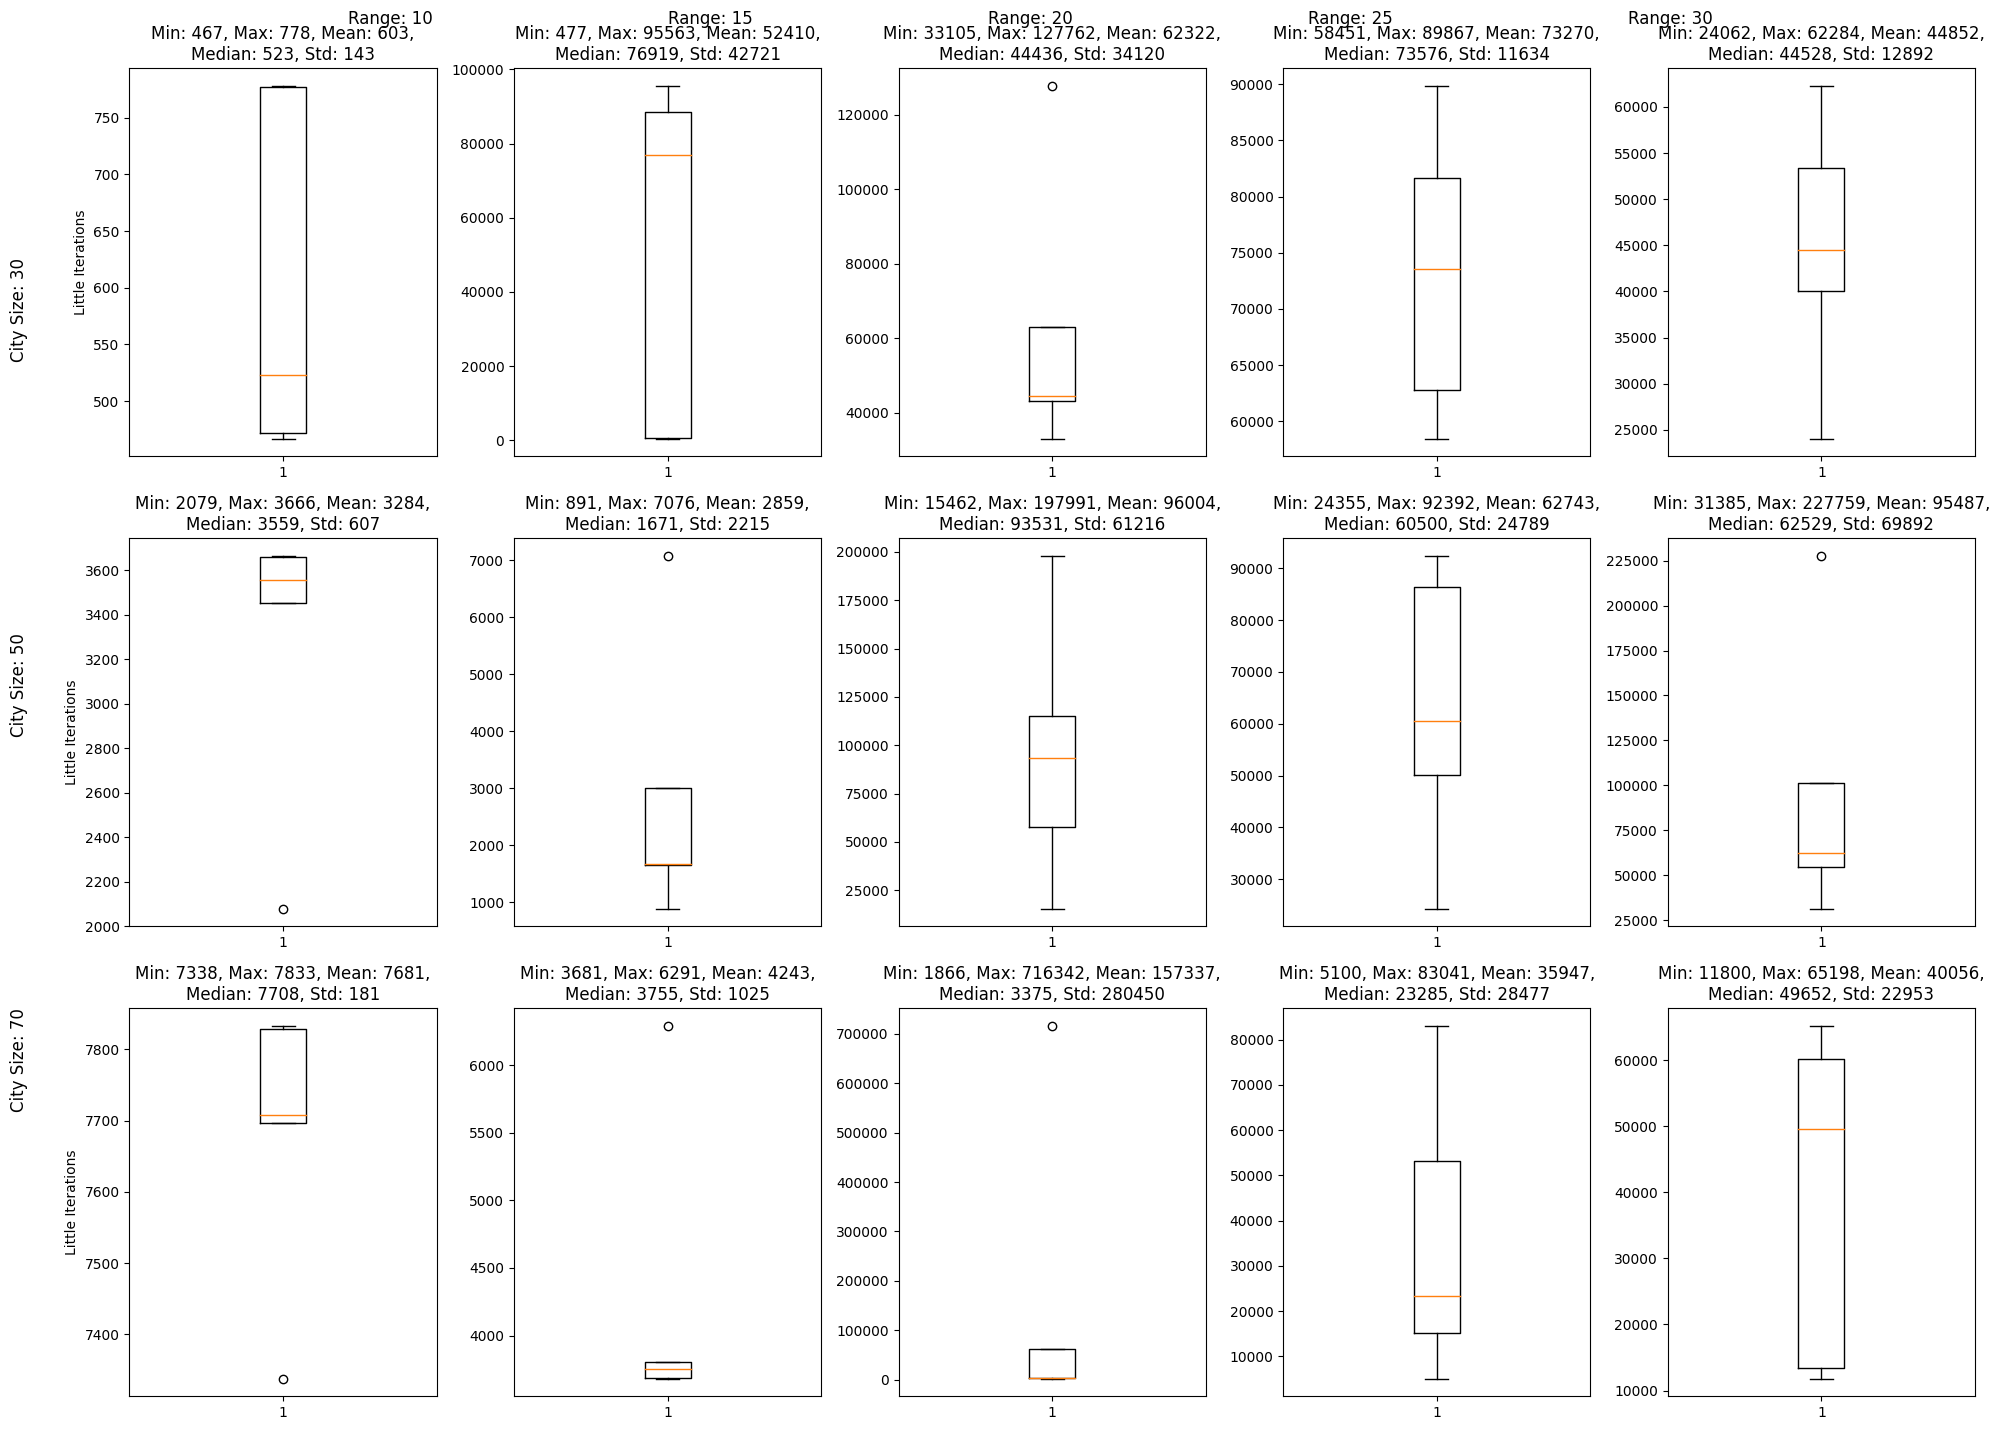

In [23]:
cities = [30, 50, 70]
ranges = [10, 15, 20, 25, 30]
results_path = 'Results/'
runs = [name for name in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, name))]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 15)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        last_y_values = []

        for run in runs:
            base_path = f"Results/{run}/results{city}_{range_val}"
            file_paths = [base_path + '.json']
            part_num = 0
            while os.path.exists(base_path + f'_{part_num}.json'):
                file_paths.append(base_path + f'_{part_num}.json')
                part_num += 1

            loaded = load_result(file_paths[-1])
            last_y_values.append(list(loaded[-1][1].values())[-1][1])

        ax = axs[i, j] if subplot_rows > 1 and subplot_cols > 1 else axs[max(i, j)]

        # Plot the boxplot for last y values
        if last_y_values:
            ax.boxplot(last_y_values)
            # Calculating statistics
            stats = np.array(last_y_values)
            min_val = np.min(stats)
            max_val = np.max(stats)
            std_val = np.std(stats)
            mean_val = np.mean(stats)
            median_val = np.median(stats)
            stats_title = (f'Min: {min_val:.0f}, Max: {max_val:.0f}, Mean: {mean_val:.0f},\n'
                           f'Median: {median_val:.0f}, Std: {std_val:.0f}')
            ax.set_title(stats_title)
        else:
            ax.set_title(f'City {city}, Range {range_val}')
        
        if j == 0:
            ax.set_ylabel('Little Iterations')

# Label the rows and columns
for idx, city in enumerate(cities):
    fig.text(0.01, 0.75 - idx * 0.25, f'City Size: {city}', va='center', ha='left', rotation='vertical', fontsize=12)

for idx, range_val in enumerate(ranges):
    fig.text(0.2 + idx * 0.16, 0.95, f'Range: {range_val}', ha='center', va='top', fontsize=12)

plt.tight_layout(rect=[0.03, 0, 1, 0.95])
plt.show()

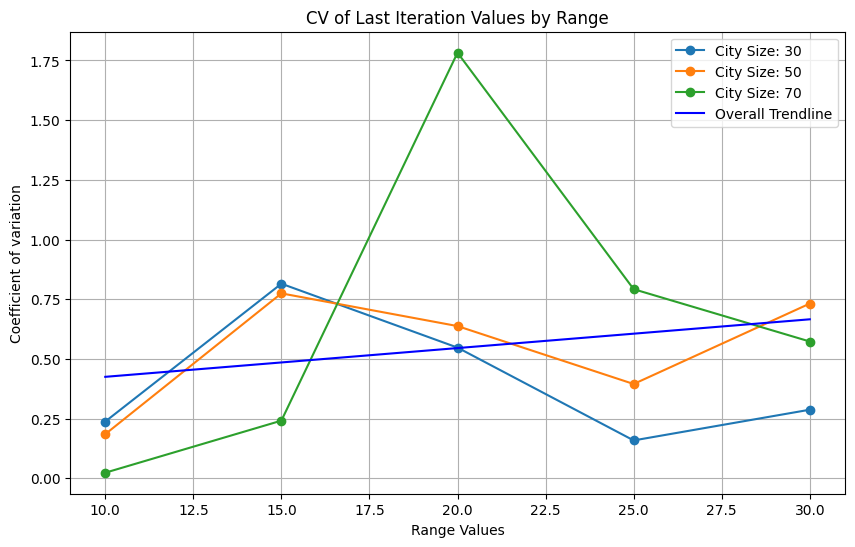

In [31]:
def remove_outliers(data):
    """Remove outliers using the IQR method."""
    quartile1, quartile3 = np.percentile(data, [25, 75])
    iqr = quartile3 - quartile1
    lower_bound = quartile1 - 1.5 * iqr
    upper_bound = quartile3 + 1.5 * iqr
    return [x for x in data if lower_bound <= x <= upper_bound]

cities = [30, 50, 70]
ranges = [10, 15, 20, 25, 30]
results_path = 'Results/'
runs = [name for name in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, name))]

# Prepare a dictionary to store std values for each city across ranges
std_data = {city: [] for city in cities}
overall_std = []
overall_ranges = []

for city in cities:
    for range_val in ranges:
        last_y_values = []

        for run in runs:
            base_path = f"Results/{run}/results{city}_{range_val}"
            file_paths = [base_path + '.json']
            part_num = 0
            while os.path.exists(base_path + f'_{part_num}.json'):
                file_paths.append(base_path + f'_{part_num}.json')
                part_num += 1

            # Assuming load_result correctly loads the last required result
            loaded = load_result(file_paths[-1])
            last_y_values.append(list(loaded[-1][1].values())[-1][1])

        # Remove outliers and compute the standard deviation
        if last_y_values:
            filtered_values = remove_outliers(last_y_values)
            if filtered_values:
                std_val = np.std(filtered_values)/np.mean(filtered_values)
            else:
                std_val = 0  # Default to 0 if all values are outliers or filtering removes all data
            std_data[city].append(std_val)
            overall_std.append(std_val)
            overall_ranges.append(range_val)
        else:
            std_data[city].append(0)  # Append zero if no data is present

# Plotting the results
plt.figure(figsize=(10, 6))
for city, stds in std_data.items():
    plt.plot(ranges, stds, marker='o', label=f'City Size: {city}')

# Fitting and plotting the overall trendline
if overall_std:
    z_overall = np.polyfit(overall_ranges, overall_std, 1)
    p_overall = np.poly1d(z_overall)
    plt.plot(ranges, p_overall(ranges), "b-", label='Overall Trendline')  # Plot overall trendline

plt.title('CV of Last Iteration Values by Range (Outliers removed)')
plt.xlabel('Range Values')
plt.ylabel('Coefficient of variation')
plt.legend()
plt.grid(True)
plt.show()

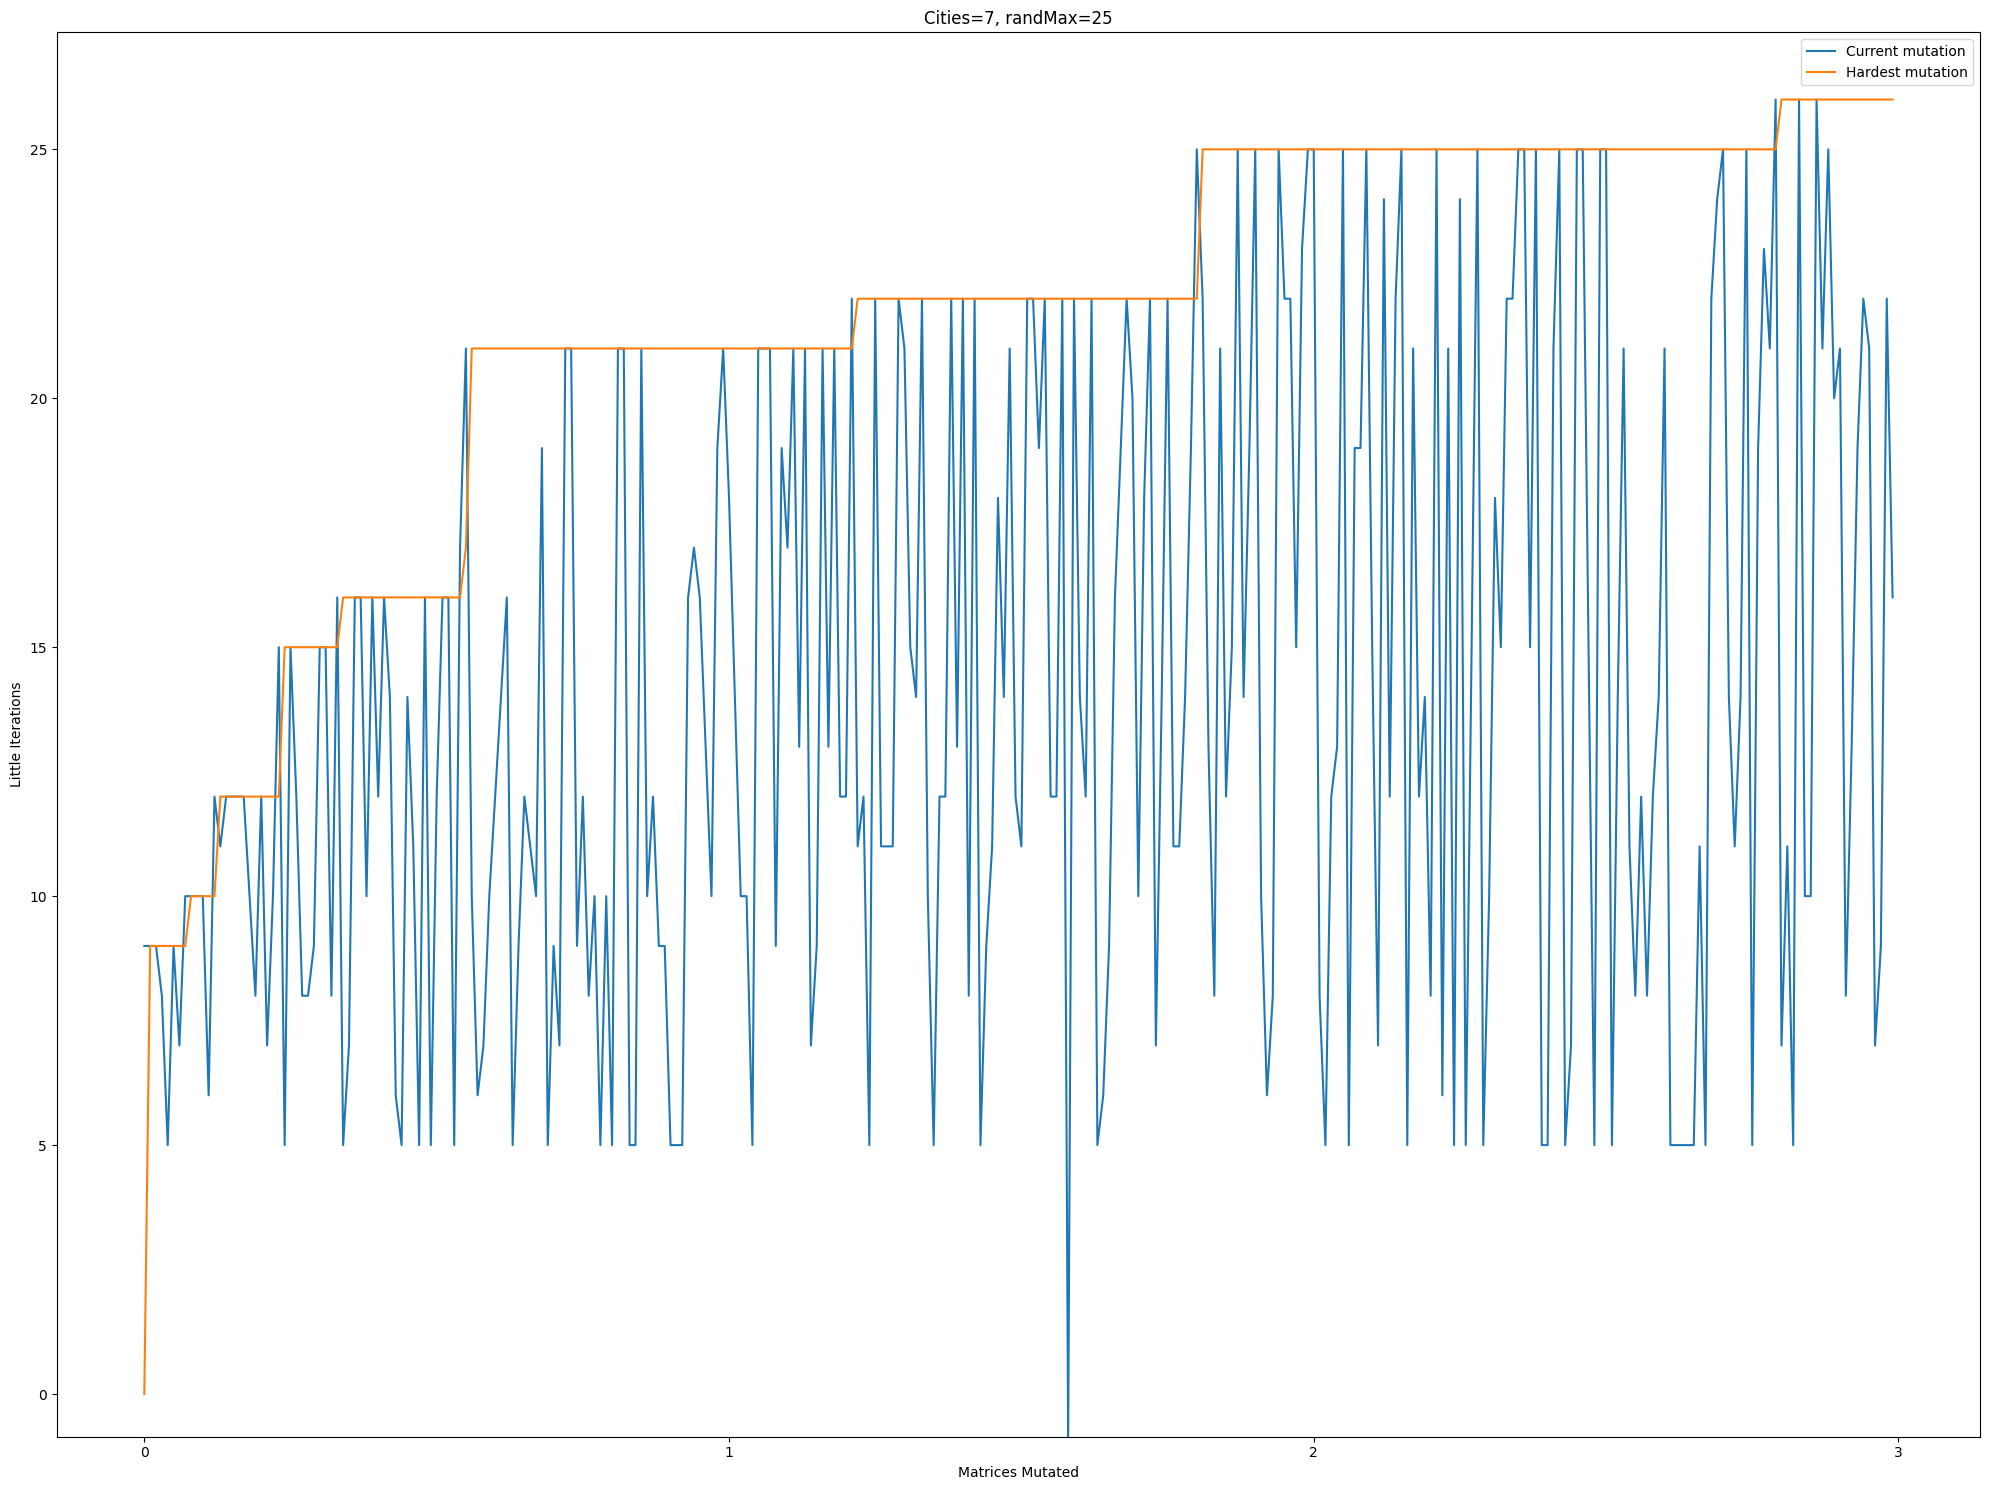

In [17]:
cities = [30,50,70]
ranges = [10,15,20,25,30]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 15)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}.json"
        try:
           loaded = load_result(path)
        except:
           continue
        
        wallClock = 0
        x_values = []
        y_values_1 = []

        for hundred_gens in loaded:
            # Retrieve data from the current batch
            wallClock += hundred_gens[0]
            current_x_values = list(hundred_gens[1].keys())
            current_y_values_1 = [values[1] for values in hundred_gens[1].values()]

            x_values.extend(current_x_values)
            y_values_1.extend(current_y_values_1)
        
        if subplot_rows == 1 and subplot_cols == 1:
            ax = axs
            ax.set_xlabel('Matrices Mutated')
        else:
            if subplot_rows > 1 and subplot_cols > 1:
                ax = axs[i, j]
            elif subplot_rows > 1:
                ax = axs[i]
            else:
                ax = axs[j]

        ax.plot(x_values, y_values_1, label='Hardest mutation')
        xticklist = list(range(0, int(x_values[-1]) + 5, 100))
        if len(xticklist) > 39:
            xticklist = xticklist[::4]  # Reduce the number of ticks by taking every 2nd tick
        elif len(xticklist) > 19:
            xticklist = xticklist[::2]
        
        ax.set_xticks(xticklist)
        ax.set_xticklabels([f"{x//100}" for x in xticklist])

        ax.set_ylim(bottom=min(y_values_1)-(min(y_values_1)/7))
        if j == 0:
          ax.set_ylabel('Little Iterations')
        if i == 2:
            ax.set_xlabel('Generations in Hundreds')
        try:
            ax.set_title(f'Cities={city}, randMax={range_val}, wallClockTime={round(wallClock/3600, 2)}h')
        except:
            ax.set_title(f'Cities={city}, randMax={range_val}')
        if i == 0 & j== 0:
          ax.legend()

plt.tight_layout()
plt.show()

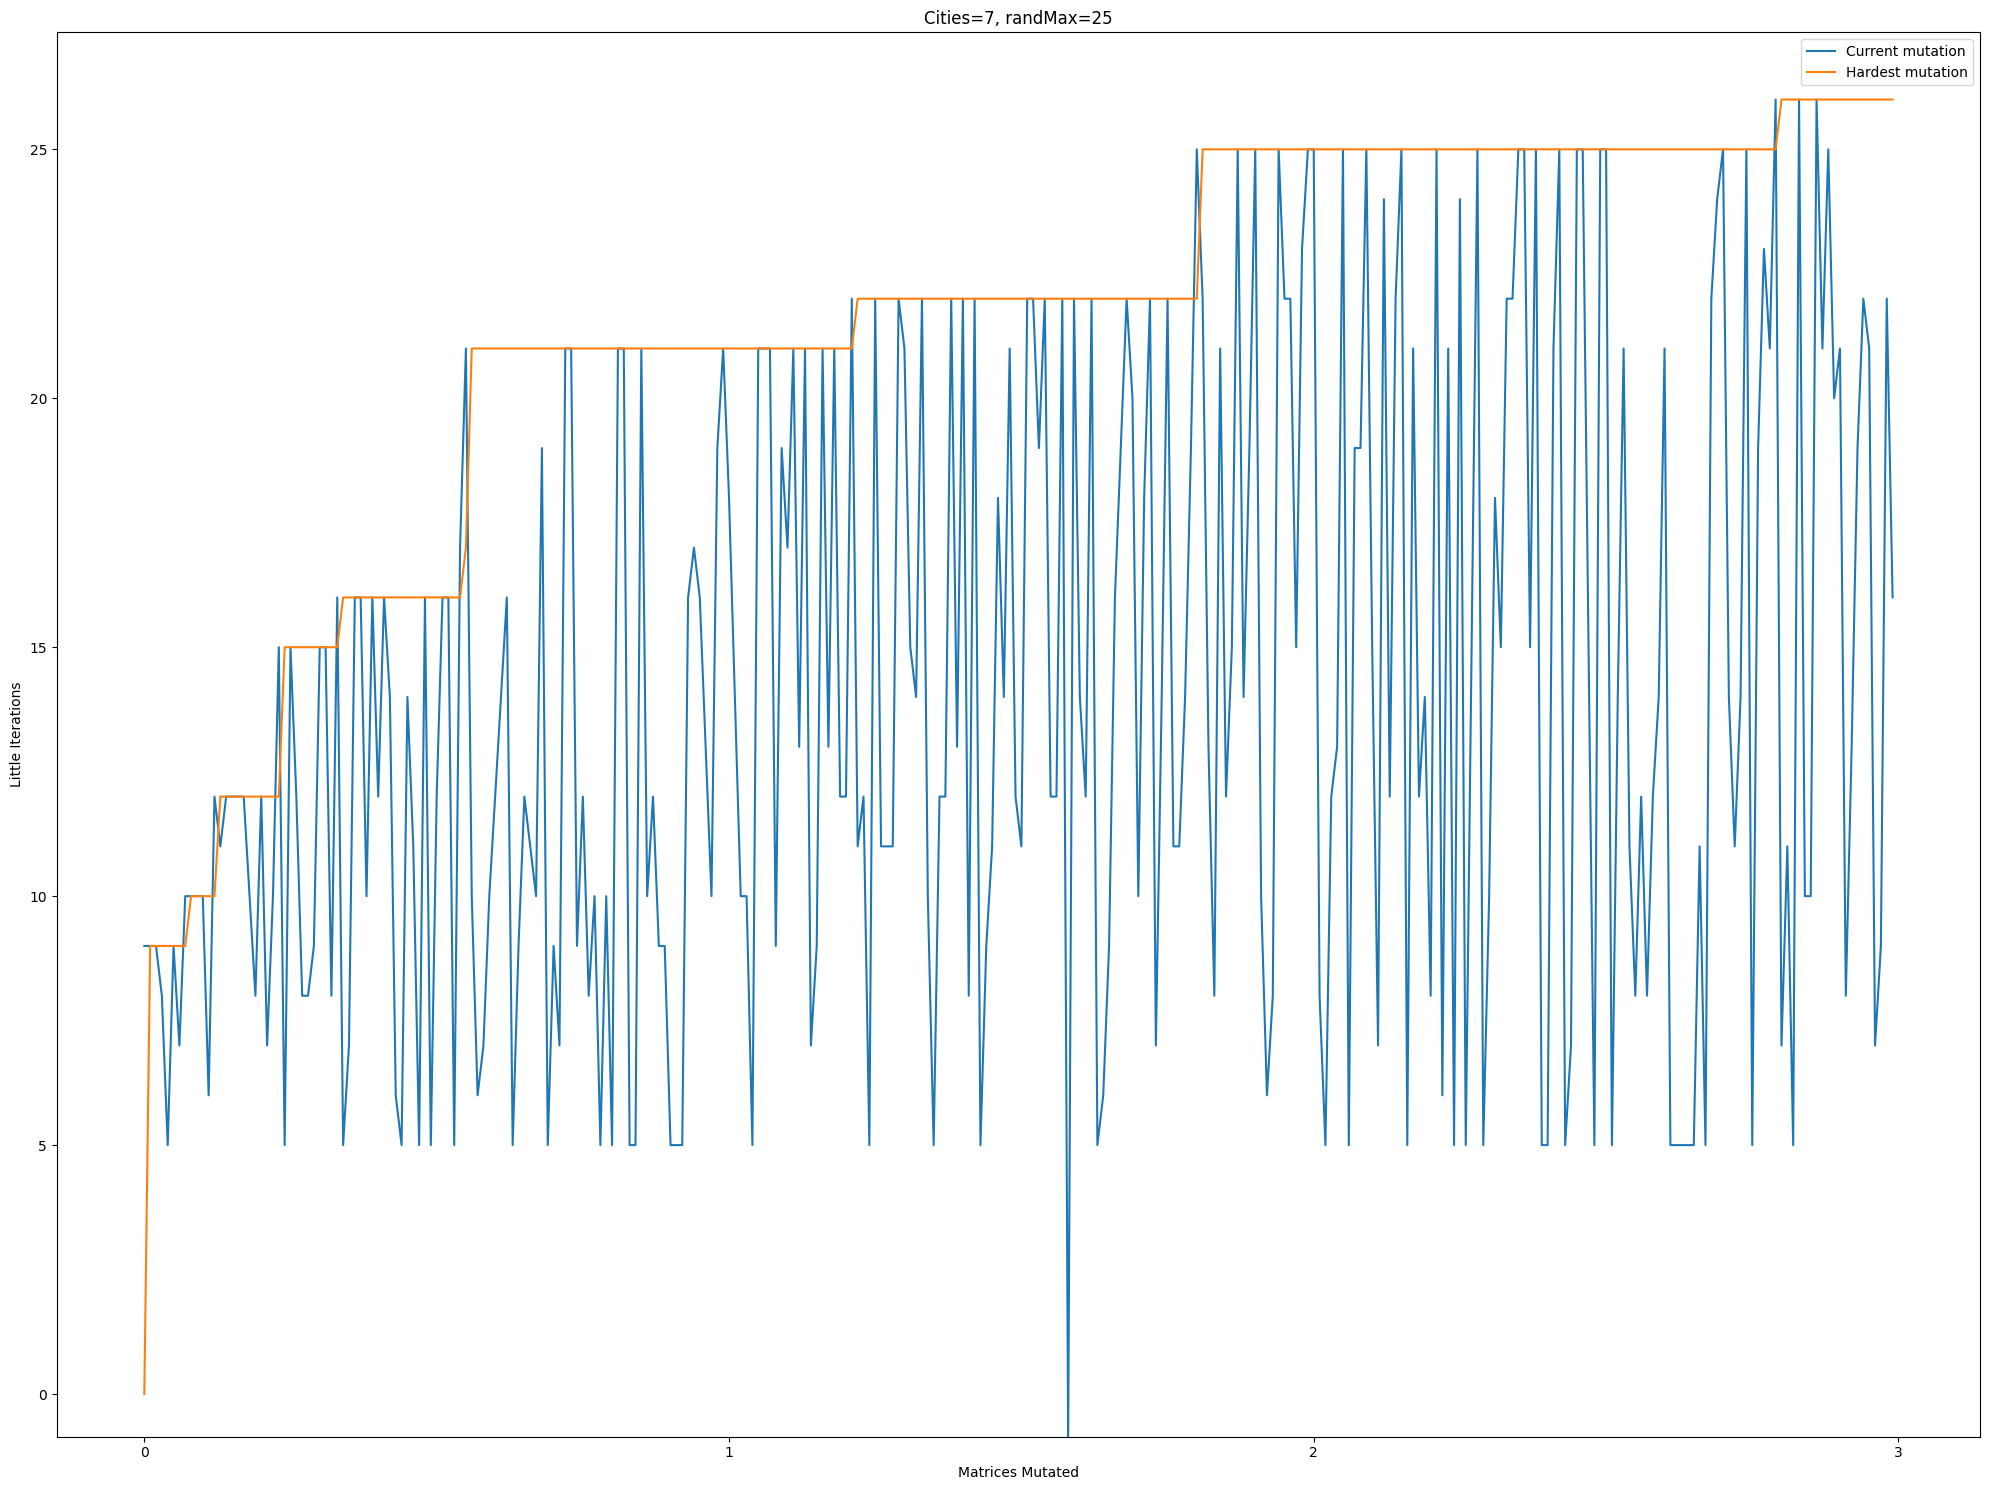

In [ ]:
cities = [7]
ranges = [25]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 15)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}.json"
        try:
           loaded = load_result(path)
        except:
           continue
        
        x_values = []
        y_values_0 = []
        y_values_1 = []

        for hundred_gens in loaded:
            # Retrieve data from the current batch
            current_x_values = list(hundred_gens[1].keys())
            current_y_values_0 = [values[0] for values in hundred_gens[1].values()]
            current_y_values_1 = [values[1] for values in hundred_gens[1].values()]

            x_values.extend(current_x_values)
            y_values_0.extend(current_y_values_0)
            y_values_1.extend(current_y_values_1)
        
        if subplot_rows == 1 and subplot_cols == 1:
            ax = axs
            ax.set_xlabel('Matrices Mutated')
        else:
            if subplot_rows > 1 and subplot_cols > 1:
                ax = axs[i, j]
            elif subplot_rows > 1:
                ax = axs[i]
            else:
                ax = axs[j]

        ax.plot(x_values, y_values_0, label='Current mutation')
        ax.plot(x_values, y_values_1, label='Hardest mutation')
        xticklist = list(range(0, int(x_values[-1]) + 5, 100))
        if len(xticklist) > 39:
            xticklist = xticklist[::4]  # Reduce the number of ticks by taking every 2nd tick
        elif len(xticklist) > 19:
            xticklist = xticklist[::2]
        
        ax.set_xticks(xticklist)
        ax.set_xticklabels([f"{x//100}" for x in xticklist])

        times = {'30_10':4910+5319, '30_15':35064+106213, '30_20':64972+172139, '30_30':67441, '50_10':89062, '50_15':59532+75186, '50_20':20976+92754, '50_30':50168, '70_10':215677, '70_15':171107, '70_20':87024+99970}

        ax.set_ylim(bottom=min(y_values_0)-(min(y_values_0)/7))
        if j == 0:
          ax.set_ylabel('Little Iterations')
        if i == 2:
            ax.set_xlabel('Generations in Hundreds')
        try:
            ax.set_title(f'Cities={city}, randMax={range_val}, wallClockTime={round(times[f"{city}_{range_val}"]/3600, 2)}h')
        except:
            ax.set_title(f'Cities={city}, randMax={range_val}')
        if i == 0 & j== 0:
          ax.legend()

plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

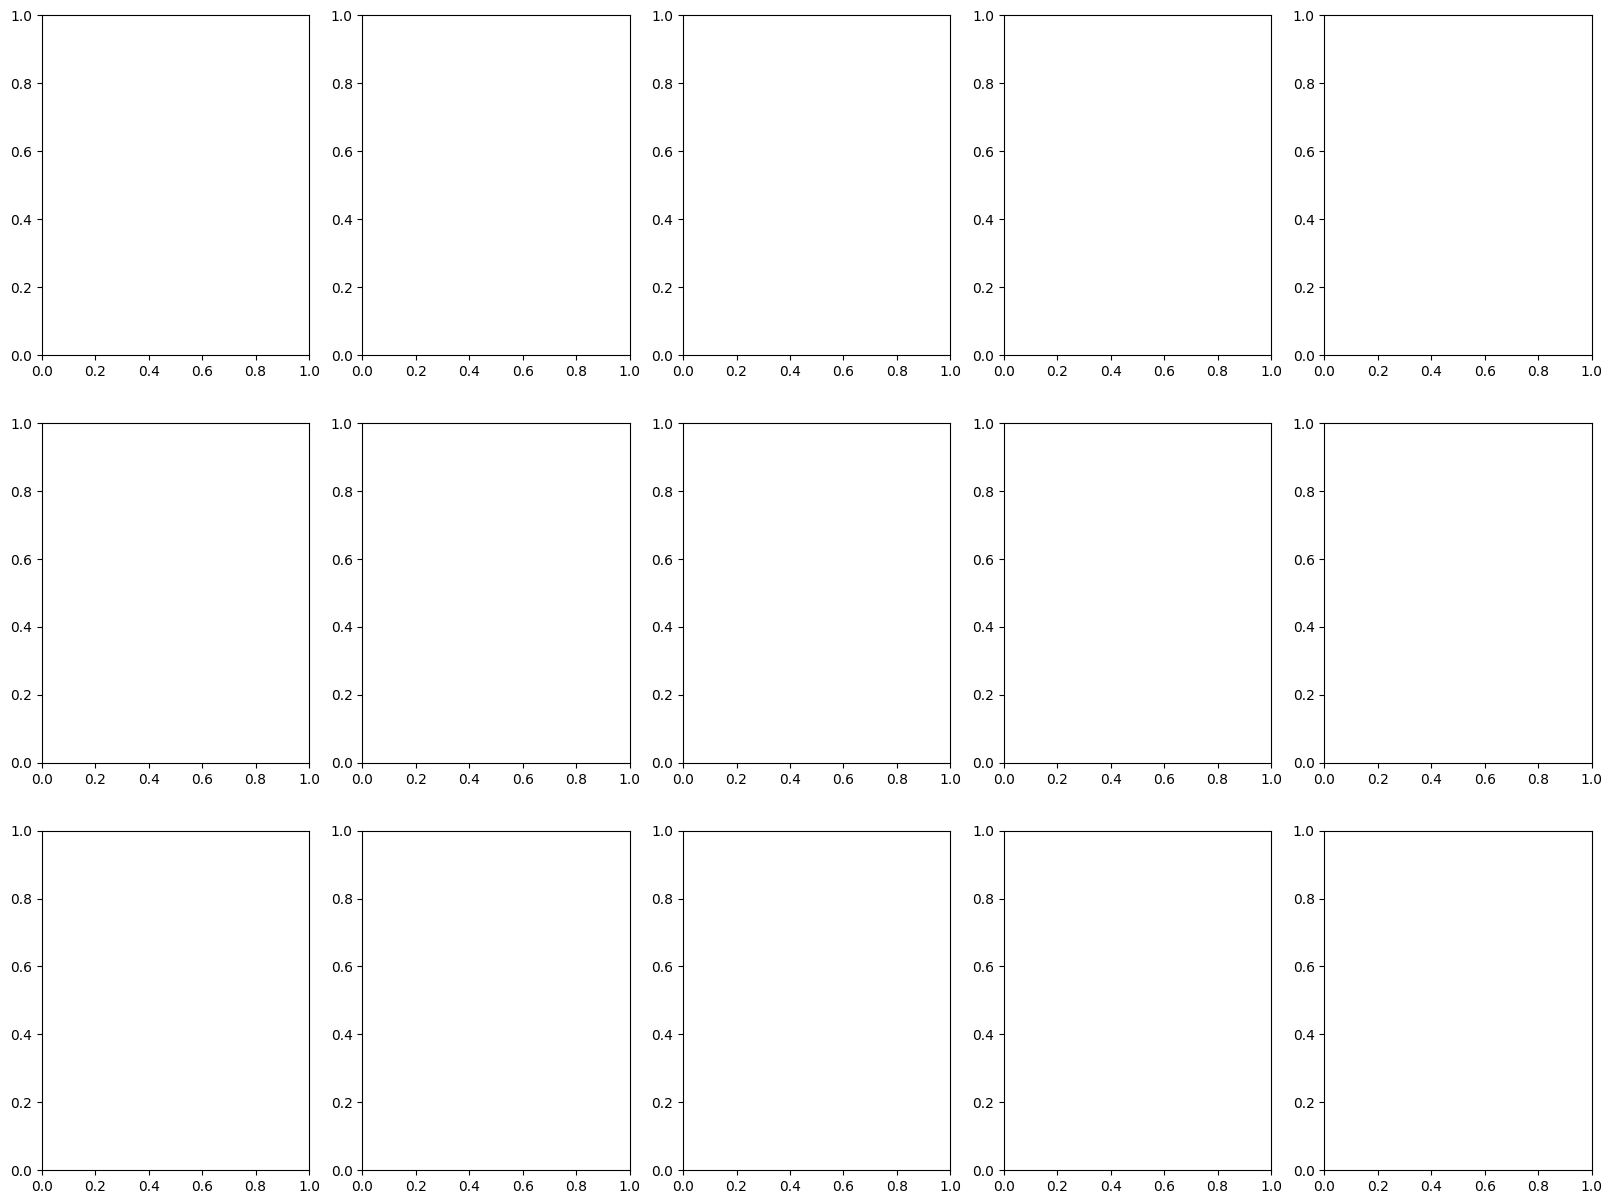

In [ ]:
cities = [30, 50, 70]
ranges = [10, 15, 20, 25, 30]
runs = ['6019314_run1', '6019314_run2', '6019314_run3', '6019314_run4', '6019314_run5']

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 15)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        # Initialize variables for holding the maximum set of x-values across all runs for consistent plotting.
        max_x_values = []
        run_data = []
        times = np.zeros(len(runs))

        for k, run in enumerate(runs):
            path = f"Results/{run}/results{city}_{range_val}.json"
            try:
                loaded = load_result(path)
            except:
                continue
            
            x_values = []
            y_values_1 = []

            for hundred_gens in loaded:
                times[k] += hundred_gens[0]
                current_x_values = list(hundred_gens[1].keys())
                current_y_values_1 = [values[1] for values in hundred_gens[1].values()]

                x_values.extend(current_x_values)
                y_values_1.extend(current_y_values_1)

            if len(x_values) > len(max_x_values):
                max_x_values = x_values  # Update max_x_values if current x_values is longer
            run_data.append((x_values, y_values_1))
            

        if subplot_rows == 1 and subplot_cols == 1:
            ax = axs
        else:
            if subplot_rows > 1 and subplot_cols > 1:
                ax = axs[i, j]
            elif subplot_rows > 1:
                ax = axs[i]
            else:
                ax = axs[j]

        # Plot each run's data
        for x_vals, y_vals in run_data:
            ax.plot(x_vals, y_vals)

        # Configure the x-axis ticks and labels
        xticklist = list(range(0, int(max_x_values[-1]) + 5, 100))
        if len(xticklist) > 39:
            xticklist = xticklist[::4]
        elif len(xticklist) > 19:
            xticklist = xticklist[::2]
        
        ax.set_xticks(xticklist)
        ax.set_xticklabels([f"{x//100}" for x in xticklist])

        # Adjust y-axis limit based on the data
        all_y_values = [item for sublist in run_data for item in sublist[1]]
        ax.set_ylim(bottom=min(all_y_values)-(min(all_y_values)/7))
        if j == 0:
            ax.set_ylabel('Little Iterations')
        if i == 2:
            ax.set_xlabel('Generations in Hundreds')
        formatted_string = ', '.join(map(str, (times/3600).round(2)))
        ax.set_title(f'WCTs={formatted_string}h')
        
        if (i == 0 and j == 0) or (i == 1 and j == 2) or (i == 2 and j == 4):
            ax.legend(['Run1', 'Run2', 'Run3', 'Run4', 'Run5'])

# Label the rows and columns
for idx, city in enumerate(cities):
    fig.text(0.01, 0.75 - idx * 0.25, f'City Size: {city}', va='center', ha='left', rotation='vertical', fontsize=12)

for idx, range_val in enumerate(ranges):
    fig.text(0.2 + idx * 0.16, 0.95, f'Range: {range_val}', ha='center', va='top', fontsize=12)

plt.tight_layout(rect=[0.03, 0, 1, 0.95])  # Adjust the layout to make room for labels
plt.show()

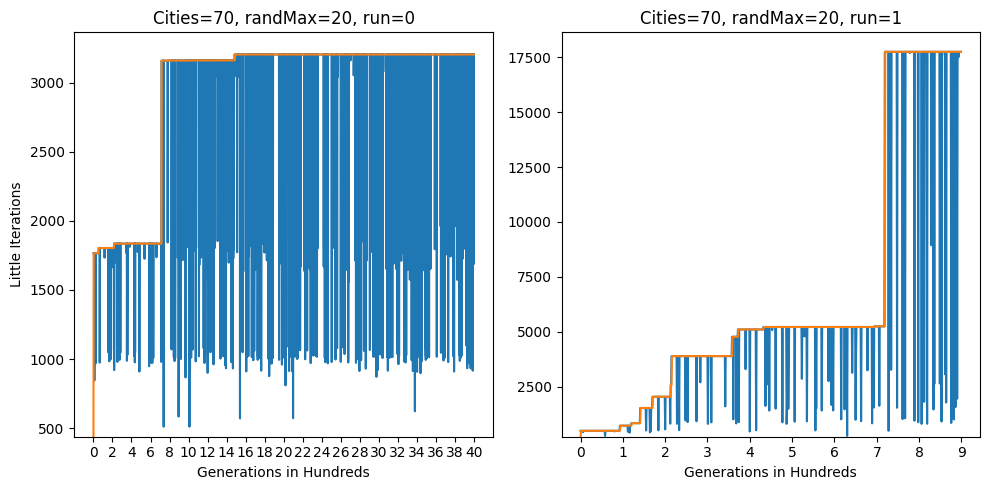

In [11]:
cities = [70]
runs = [0,1]

subplot_rows = len(cities)
subplot_cols = len(runs)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(10, 5)) 

for i, city in enumerate(cities):
    for j, run_val in enumerate(runs):
        path = f"Results/results{city}_20_{run_val}.json"
        try:
           loaded = load_result(path)
        except:
           continue
        
        x_values = list(loaded.keys())
        y_values_0 = [values[0] for values in loaded.values()]  
        y_values_1 = [values[1] for values in loaded.values()] 
        
        if subplot_rows == 1 and subplot_cols == 1:
            ax = axs
            ax.set_xlabel('Matrices Mutated')
        else:
            if subplot_rows > 1 and subplot_cols > 1:
                ax = axs[i, j]
            elif subplot_rows > 1:
                ax = axs[i]
            else:
                ax = axs[j]

        ax.plot(x_values, y_values_0, label='Current mutation')
        ax.plot(x_values, y_values_1, label='Hardest mutation')

        xticklist = list(range(0, int(x_values[-1]) + 5, 100))
        if len(xticklist) > 20:
            xticklist = xticklist[::2]  # Reduce the number of ticks by taking every 2nd tick
        
        ax.set_xticks(xticklist)
        ax.set_xticklabels([f"{x//100}" for x in xticklist])

        ax.set_ylim(bottom=min(y_values_0)-(min(y_values_0)/7))
        if j == 0:
          ax.set_ylabel('Little Iterations')
        ax.set_xlabel('Generations in Hundreds')
        ax.set_title(f'Cities={city}, randMax=20, run={run_val}')
        if i == 1 & j== 1:
          ax.legend()

plt.tight_layout()
plt.show()

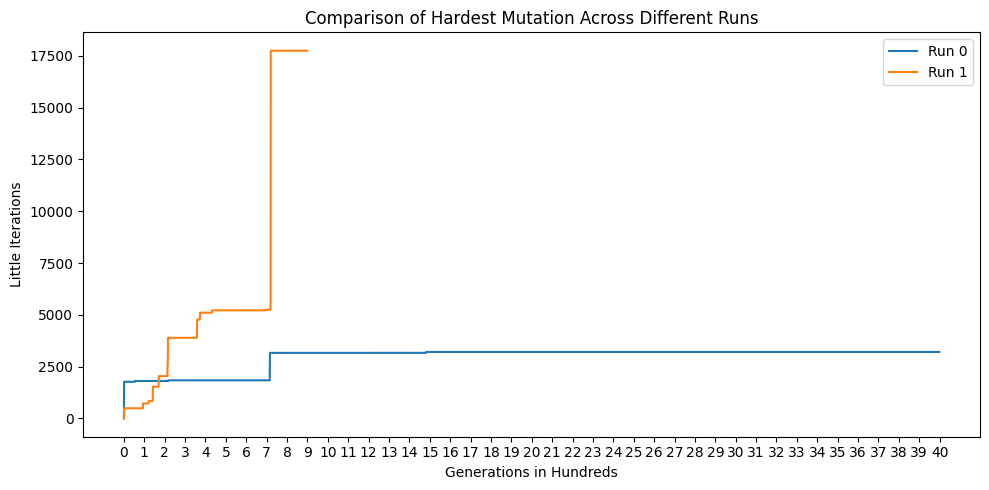

In [13]:
import matplotlib.pyplot as plt
import json

cities = [70]
runs = [0, 1]

# Function to load results from a file
def load_result(path):
    with open(path, 'r') as file:
        return json.load(file)

# Prepare to store the x values and y values for the hardest mutation
x_values_run0 = []
y_values_run0 = []
y_values_run1 = []

# Load and process data
for city in cities:
    for run_val in runs:
        path = f"Results/results{city}_20_{run_val}.json"
        try:
            loaded = load_result(path)
        except FileNotFoundError:
            print(f"File not found: {path}")
            continue

        if run_val == 0:  # Take x-values and y-values from run 0
            x_values_run0 = list(loaded.keys())
            y_values_run0 = [values[1] for values in loaded.values()]  # Hardest mutation
        else:
            x_values_run1 = list(loaded.keys())
            y_values_run1 = [values[1] for values in loaded.values()]  # Hardest mutation for run 1

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot for run 0
ax.plot(x_values_run0, y_values_run0, label='Run 0')

# Plot for run 1
if y_values_run1:  # Ensure there is data for run 1
    ax.plot(x_values_run1, y_values_run1, label='Run 1')

# Customize the graph
xticklist = list(range(0, int(x_values_run0[-1]) + 5, 100))
xticklabellist = list(range(0, int(x_values_run0[-1]) + 5, 100))
ax.set_xticks(xticklist)
ax.set_xticklabels([round(x / 100) for x in xticklabellist])

ax.set_xlabel('Generations in Hundreds')
ax.set_ylabel('Little Iterations')
ax.set_title('Comparison of Hardest Mutation Across Different Runs')
ax.legend()

plt.tight_layout()
plt.show()

### Analysis 4: Characteristics on the data

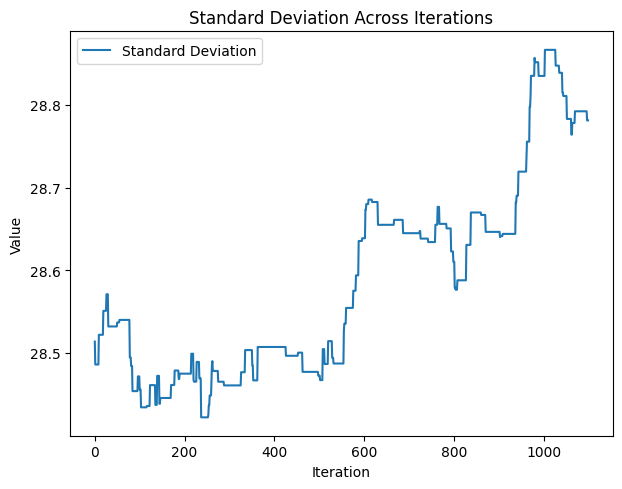

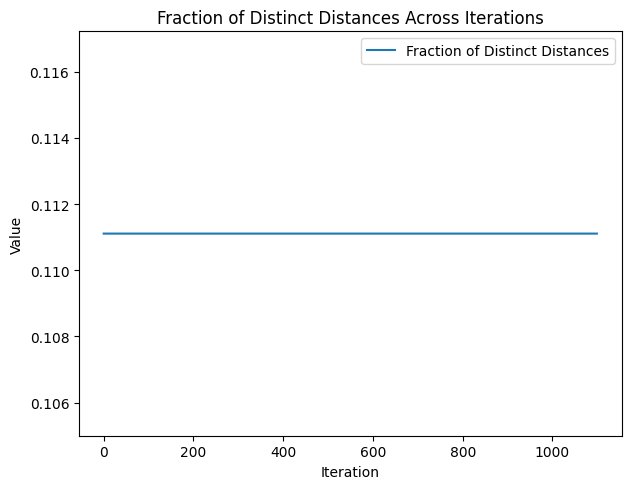

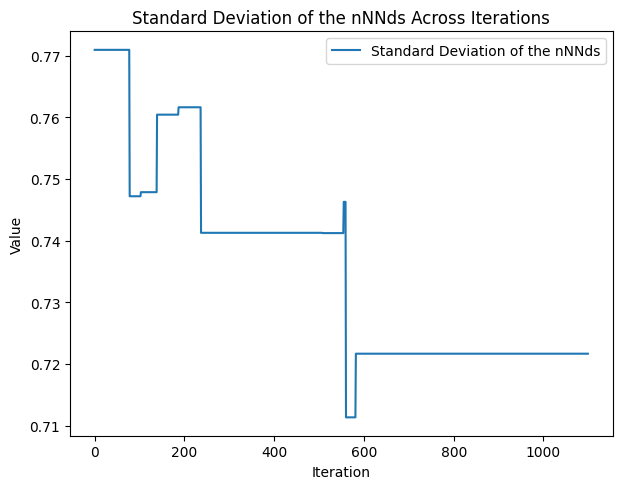

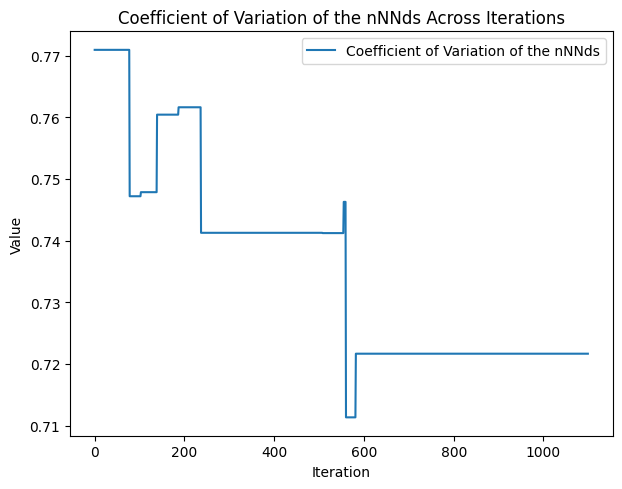

In [12]:
path = f"Results/results30_100_0.json"
loaded = load_result(path)
l = []

hardest_matrices = []
for values in loaded.values():
    if values[0] > values[1]:
        hardest_matrices.append(values[4])
    else:
        hardest_matrices.append(hardest_matrices[-1])

for x in hardest_matrices:
    # Excluding infinite values for some calculations
    finite_distances = np.ma.masked_invalid(x)

    # 1. Standard Deviation (SD)
    sd = np.std(finite_distances)

    # 4. Fraction of Distinct Distances
    unique_distances = np.unique(finite_distances)
    fraction_distinct = unique_distances.size / finite_distances.size

    # 6. Standard Deviation of the Normalized Nearest-Neighbour Distances (nNNd)
    nearest = np.min(x, axis=1)
    mean_nearest = np.mean(nearest)
    normalized_nNNd = nearest / mean_nearest
    sd_nNNd = np.std(normalized_nNNd)

    # 7. Coefficient of Variation of the nNNds
    cv_nNNd = sd_nNNd / np.mean(normalized_nNNd)

    l.append([sd, fraction_distinct, sd_nNNd, cv_nNNd])

data = np.array(l)
for i, x in enumerate(['Standard Deviation', 'Fraction of Distinct Distances', 
                        'Standard Deviation of the nNNds',
                        'Coefficient of Variation of the nNNds']):
    plt.figure(figsize=(7, 5.25))
    plt.plot(data[:, i], label=x)
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'{x} Across Iterations')
    plt.legend()
    plt.show()

#### Standard deviation

30 cities, between 1 and 10, pearson statistic: -0.041, Pvalue: 0.8945645098
30 cities, between 1 and 100, pearson statistic: 0.927, Pvalue: 0.0
30 cities, between 1 and 1000, pearson statistic: 0.888, Pvalue: 0.0
50 cities, between 1 and 10, pearson statistic: 0.869, Pvalue: 0.0555836474
50 cities, between 1 and 100, pearson statistic: 0.856, Pvalue: 0.0
50 cities, between 1 and 1000, pearson statistic: 0.937, Pvalue: 0.0
Pvalue rounded to 10 decimals


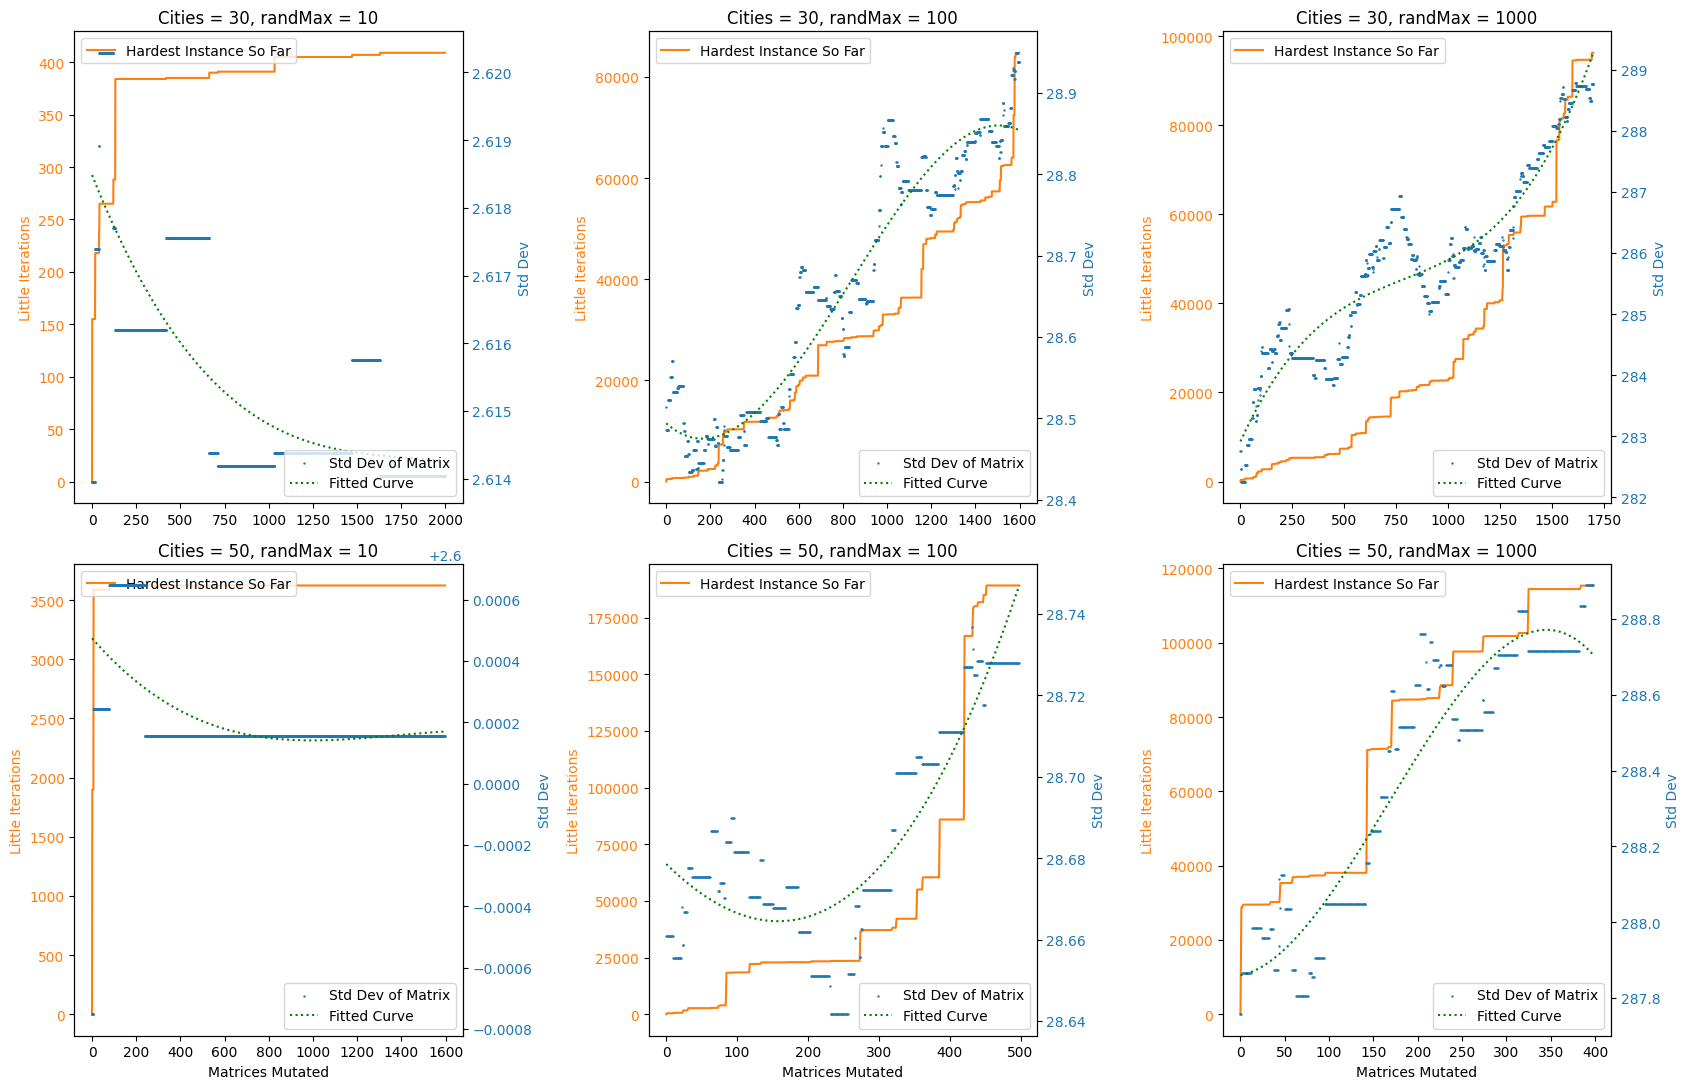

In [15]:
from scipy.stats import pearsonr

cities = [30, 50]
ranges = [10, 100, 1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(17, 11)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)
        
        # matrices of hardest instances at every mutation
        hardest_matrices = []
        for values in loaded.values():
            if values[0] > values[1]:
                hardest_matrices.append(values[4])
            else:
                hardest_matrices.append(hardest_matrices[-1])
        
        # these are just list comprehensions but instead of lists they are numpy arrays
        # numpy arrays make it easy to remove duplicates before we get to the correlation calculation
        y_values_std = np.fromiter((np.std(np.ma.masked_invalid(x)) for x in hardest_matrices), float)
        y_values = np.fromiter((values[1] for values in loaded.values()), float)
        x_values = list(range(len(y_values)))
        
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j] if subplot_cols > 1 else axs

        # Plot the sorted current instances
        color = 'tab:orange'
        ax.plot(x_values, y_values, label='Hardest Instance So Far', color=color)
        ax.set_ylabel('Little Iterations', color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # Create a twin y-axis to plot the standard deviation
        ax2 = ax.twinx()
        color = 'tab:blue'
        ax2.scatter(x_values, y_values_std, label='Std Dev of Matrix', color=color, s=0.5)
        ax2.set_ylabel('Std Dev', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot the fitted curve
        poly_deg = 3
        ax2.plot(x_values, np.poly1d(np.polyfit(x_values, y_values_std, poly_deg))(x_values), label='Fitted Curve', color='green', linestyle=':')
        
        if i == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'Cities = {city}, randMax = {range_val}')
        ax.legend(loc='upper left')
        ax2.legend(loc='lower right')
        
        # remove duplicates before pearson correlation
        y_values_std = y_values_std[np.ma.unique(y_values,True)[1]]
        y_values = y_values[np.ma.unique(y_values,True)[1]]
        
        print(f"{city} cities, between 1 and {range_val}, pearson statistic: {round(pearsonr(y_values_std, y_values)[0],3)}, Pvalue: {round(pearsonr(y_values_std, y_values)[1],10)}")
print("Pvalue rounded to 10 decimals")

plt.tight_layout()
plt.show()

#### Fraction of Distinct Distances

C:\tools\Manim\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


30 cities, between 1 and 10, pearson statistic: nan, Pvalue: nan
30 cities, between 1 and 100, pearson statistic: nan, Pvalue: nan
30 cities, between 1 and 1000, pearson statistic: 0.554, Pvalue: 0.0
50 cities, between 1 and 10, pearson statistic: nan, Pvalue: nan
50 cities, between 1 and 100, pearson statistic: nan, Pvalue: nan
50 cities, between 1 and 1000, pearson statistic: -0.681, Pvalue: 1.345e-07
Pvalue rounded to 10 decimals


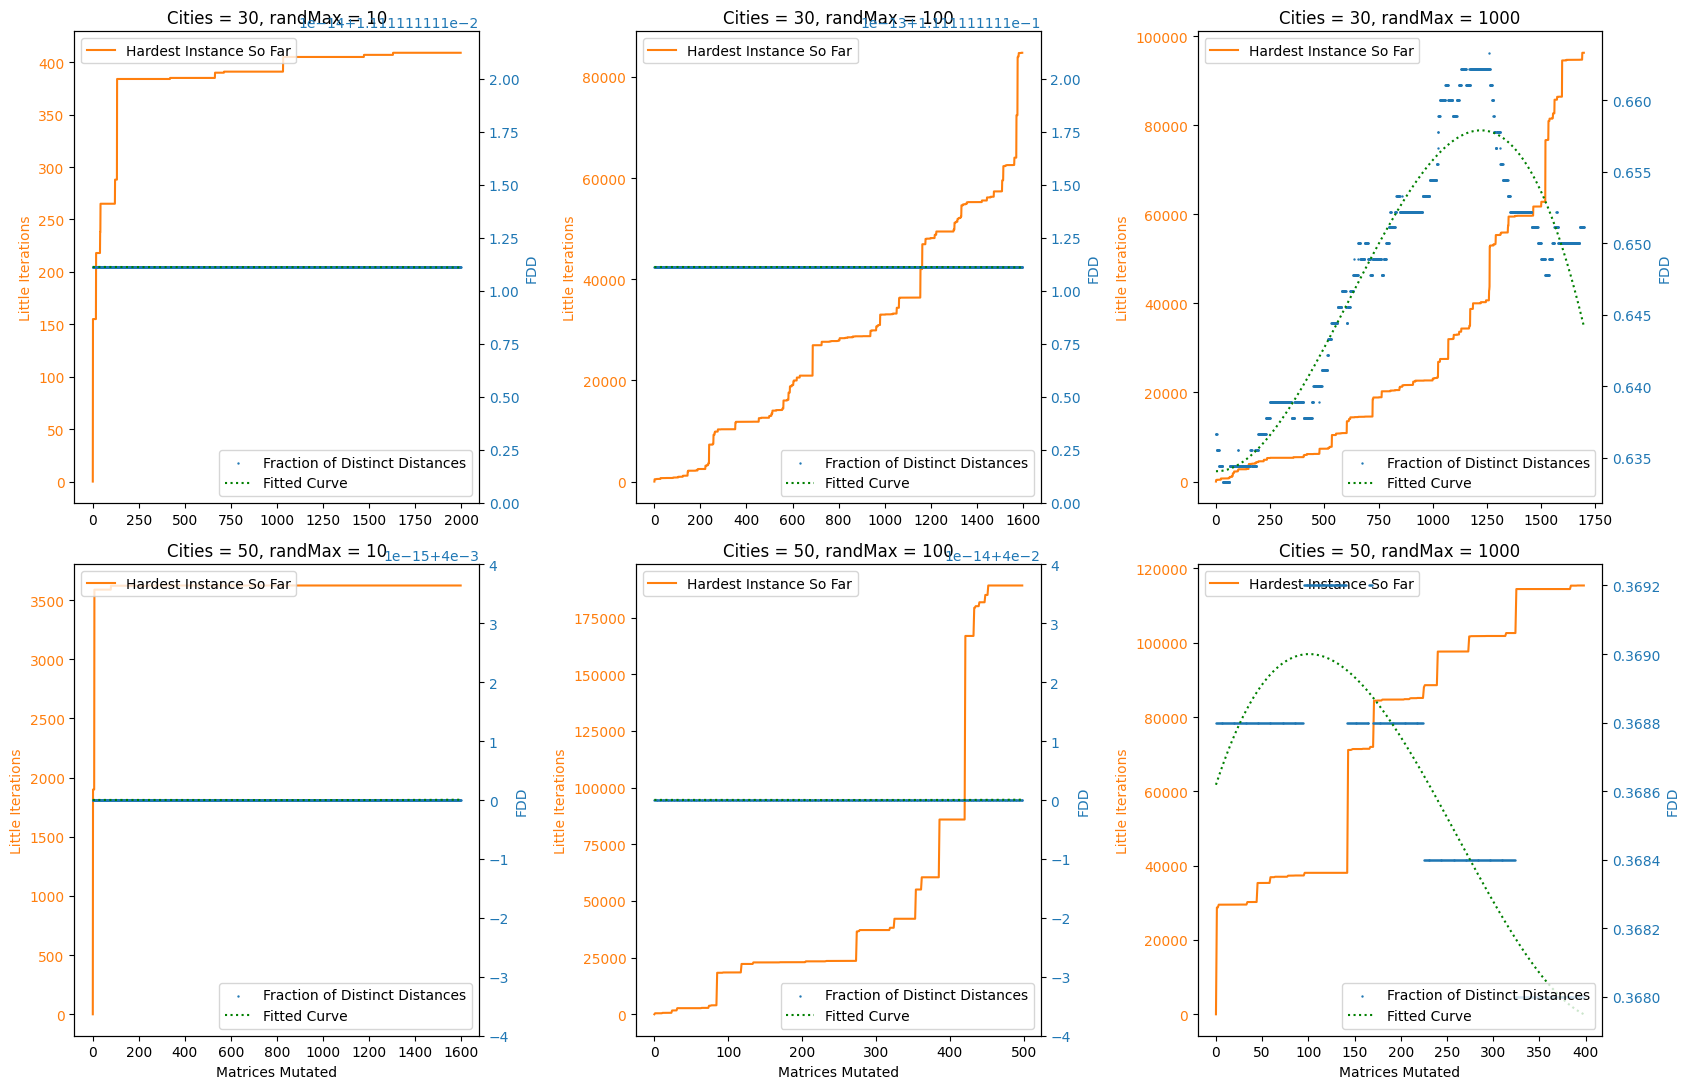

In [16]:
cities = [30, 50]
ranges = [10, 100, 1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(17, 11)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)

        # matrices of hardest instances at every mutation
        hardest_matrices = []
        for values in loaded.values():
            if values[0] > values[1]:
                hardest_matrices.append(values[4])
            else:
                hardest_matrices.append(hardest_matrices[-1])

        finite_distances = [np.ma.masked_invalid(x) for x in hardest_matrices]
        y_values_fdd = np.fromiter((np.unique(values).size / values.size for values in finite_distances),float)
        y_values = np.fromiter((values[1] for values in loaded.values()),float)
        x_values = list(range(len(y_values)))
        
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j] if subplot_cols > 1 else axs

        # Plot the sorted current instances
        color = 'tab:orange'
        ax.plot(x_values, y_values, label='Hardest Instance So Far', color=color)
        ax.set_ylabel('Little Iterations', color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # Create a twin y-axis to plot the standard deviation
        ax2 = ax.twinx()
        color = 'tab:blue'
        ax2.scatter(x_values, y_values_fdd, label='Fraction of Distinct Distances', color=color, s=0.5)
        ax2.set_ylabel('FDD', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot the fitted curve
        poly_deg = 3
        ax2.plot(x_values, np.poly1d(np.polyfit(x_values, y_values_fdd, poly_deg))(x_values), label='Fitted Curve', color='green', linestyle=':')
        
        if i == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'Cities = {city}, randMax = {range_val}')
        ax.legend(loc='upper left')
        ax2.legend(loc='lower right')

        y_values_fdd = y_values_fdd[np.ma.unique(y_values,True)[1]]
        y_values = y_values[np.ma.unique(y_values,True)[1]]
        print(f"{city} cities, between 1 and {range_val}, pearson statistic: {round(pearsonr(y_values_fdd, y_values)[0],3)}, Pvalue: {round(pearsonr(y_values_fdd, y_values)[1],10)}")
print("Pvalue rounded to 10 decimals")
    
plt.tight_layout()
plt.show()

#### Std Dev of nNNds

30 cities, between 1 and 10, pearson statistic: nan, Pvalue: nan
30 cities, between 1 and 100, pearson statistic: -0.092, Pvalue: 0.2450670921
30 cities, between 1 and 1000, pearson statistic: 0.34, Pvalue: 8.979e-07
50 cities, between 1 and 10, pearson statistic: nan, Pvalue: nan
50 cities, between 1 and 100, pearson statistic: 0.336, Pvalue: 0.0294392846
50 cities, between 1 and 1000, pearson statistic: 0.238, Pvalue: 0.1073709491
Pvalue rounded to 10 decimals


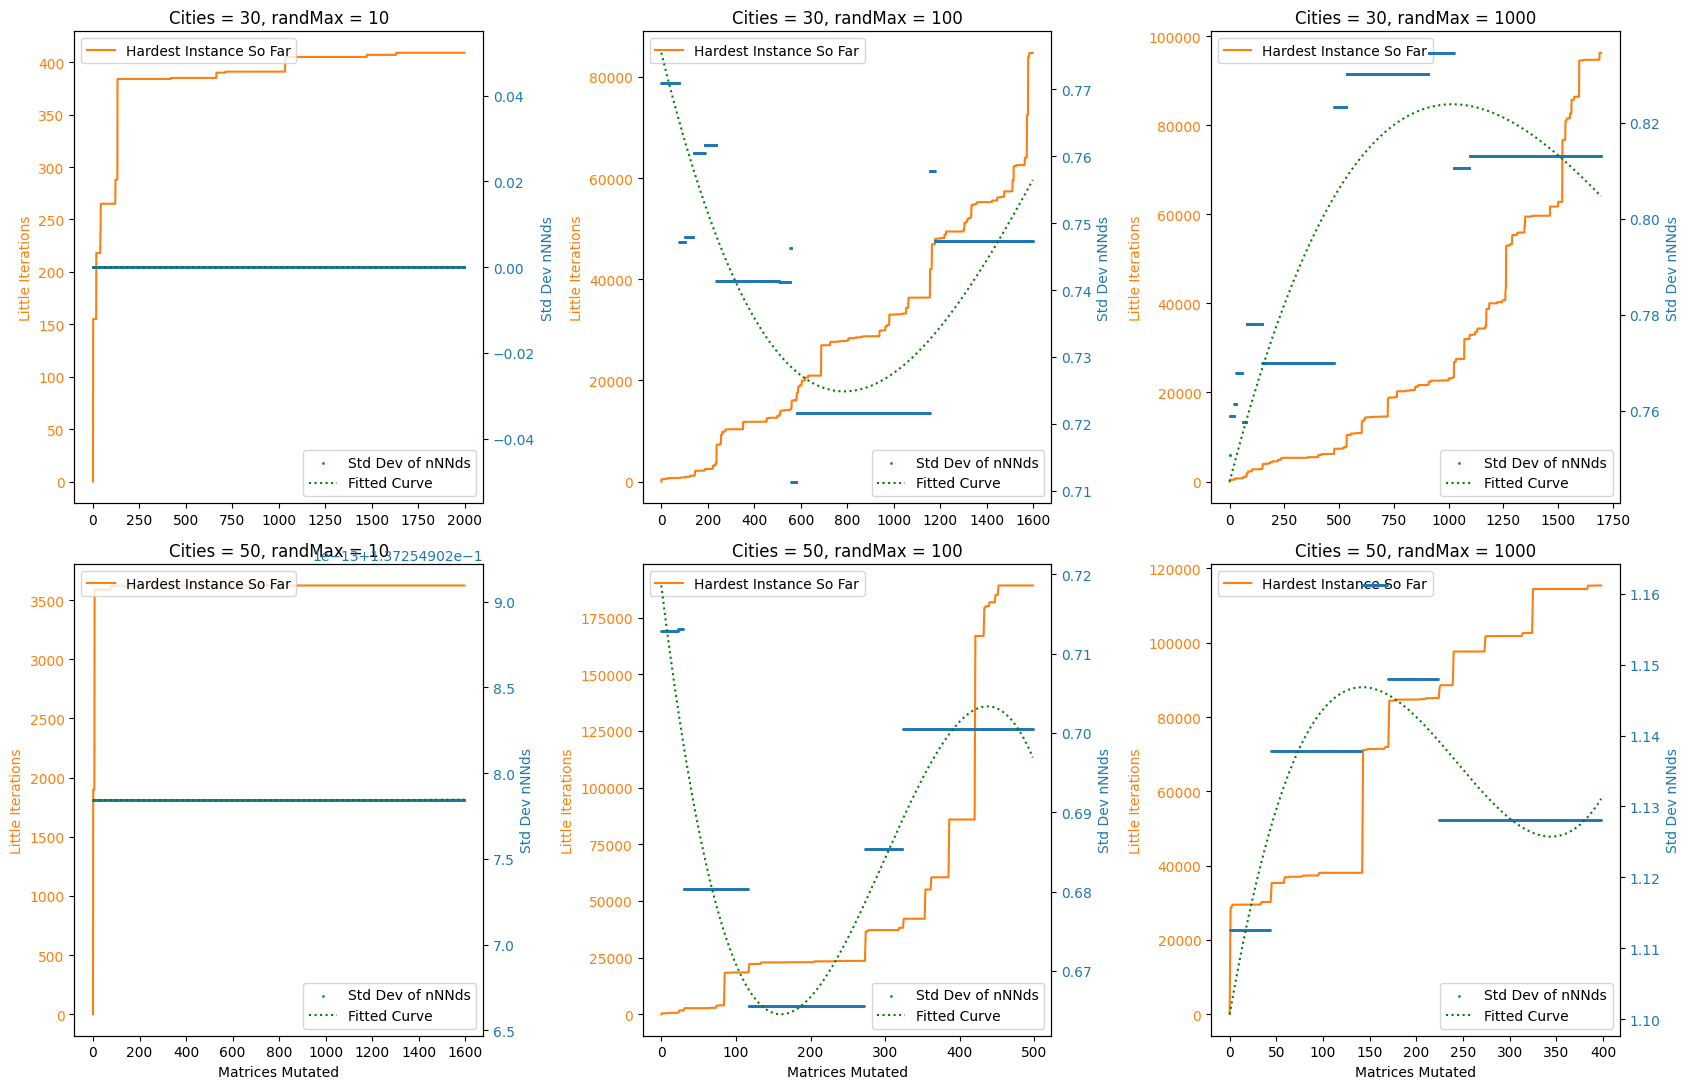

In [17]:
cities = [30, 50]
ranges = [10, 100, 1000]

subplot_rows = len(cities)
subplot_cols = len(ranges)

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(17, 11)) 

for i, city in enumerate(cities):
    for j, range_val in enumerate(ranges):
        path = f"Results/results{city}_{range_val}_0.json"
        loaded = load_result(path)

        # matrices of hardest instances at every mutation
        hardest_matrices = []
        for values in loaded.values():
            if values[0] > values[1]:
                hardest_matrices.append(values[4])
            else:
                hardest_matrices.append(hardest_matrices[-1])
        
        y_values_nearest = [np.min(x, axis=1) for x in hardest_matrices]
        y_values_mean_nearest = [np.mean(values) for values in y_values_nearest]
        # normalize distances and take std
        y_values_sd_nNNd = np.fromiter((np.std(x/y) for x,y in zip(y_values_nearest,y_values_mean_nearest)),float)

        y_values = np.fromiter((values[1] for values in loaded.values()),float)
        x_values = list(range(len(y_values)))
        
        if subplot_rows > 1 and subplot_cols > 1:
            ax = axs[i, j]
        elif subplot_rows > 1:
            ax = axs[i]
        else:
            ax = axs[j] if subplot_cols > 1 else axs

        # Plot the sorted current instances
        color = 'tab:orange'
        ax.plot(x_values, y_values, label='Hardest Instance So Far', color=color)
        ax.set_ylabel('Little Iterations', color=color)
        ax.tick_params(axis='y', labelcolor=color)

        # Create a twin y-axis to plot the standard deviation
        ax2 = ax.twinx()
        color = 'tab:blue'
        ax2.scatter(x_values, y_values_sd_nNNd, label='Std Dev of nNNds', color=color, s=1)
        ax2.set_ylabel('Std Dev nNNds', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot the fitted curve
        poly_deg = 3        
        ax2.plot(x_values, np.poly1d(np.polyfit(x_values, y_values_sd_nNNd, poly_deg))(x_values), label='Fitted Curve', color='green', linestyle=':')

        if i == 1:
          ax.set_xlabel('Matrices Mutated')
        ax.set_title(f'Cities = {city}, randMax = {range_val}')
        ax.legend(loc='upper left')
        ax2.legend(loc='lower right')

        y_values_sd_nNNd = y_values_sd_nNNd[np.ma.unique(y_values,True)[1]]
        y_values = y_values[np.ma.unique(y_values,True)[1]]
        print(f"{city} cities, between 1 and {range_val}, pearson statistic: {round(pearsonr(y_values_sd_nNNd, y_values)[0],3)}, Pvalue: {round(pearsonr(y_values_sd_nNNd, y_values)[1],10)}")
print("Pvalue rounded to 10 decimals")

plt.tight_layout()
plt.show()